In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
df_train = pd.read_csv('/dataset/signate_beginner34/train.csv')
df_test = pd.read_csv('/dataset/signate_beginner34/test.csv')
sample_submission = pd.read_csv('/dataset/signate_beginner34/sample_submission.csv')

In [10]:
df_train.columns

Index(['id', 'battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc',
       'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

In [4]:
def preprocessing(df):
    data = df.copy()
    data['sc_size'] = data['sc_h'] * data['sc_w']
    data['spec'] = data['clock_speed'] * data['n_cores']

    feature = ['int_memory', 'm_dep', 'mobile_wt',
               'pc', 'px_height', 'px_width', 'ram',
               'spec']
        # feature = ['battery_power', 'clock_speed', 'dual_sim', 'fc',
        #        'int_memory', 'm_dep', 'mobile_wt', 'n_cores',
        #        'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_size']
    return data[feature]

In [5]:
def f1(y_pred, train_data):
    N_LABELS = 4
    reshaped_preds = y_pred.reshape(N_LABELS, len(y_pred) // N_LABELS)
    y_pred_ = reshaped_preds.argmax(axis=0)
    y_true = train_data.get_label()
    score = f1_score(y_true, y_pred_, average='macro')
    return 'f1', score, True

def get_feature_importance(target_columms=None):
    '''
    特徴量の出力
    '''
    feature_imp = pd.DataFrame(sorted(zip(self.model.feature_importance(), self.target_columms)), columns=['Value','Feature'])
    return feature_imp

In [6]:
X = preprocessing(df_train)
y = df_train['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'multiclass', # 多クラス分類
    'metric': 'multi_logloss', # 損失関数にmulti_loglossを使用
    'num_class': 4, # クラスの数
    'boosting_type': 'gbdt',
    'lambda_l1': 0.2,
    'lambda_l2': 0.2,
    'learning_rate':0.01,
    'drop_rate':0.5,
    # 'max_depth': 3,
    'verbosity': -1,
}
verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
lgb_model = lgb.train(params,
                  train_data,
                  num_boost_round=10000,
                  valid_sets=[train_data, test_data],
                  feval=f1,
                  callbacks=[
                      lgb.early_stopping(stopping_rounds=10, verbose=True),
                      lgb.log_evaluation(verbose_eval) # この数字を1にすると学習時のスコア推移がコマンドライン表示される
                  ])

y_pred = lgb_model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.860773	training's f1: 0.825063	valid_1's multi_logloss: 1.15761	valid_1's f1: 0.427836


array([2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2,
       2, 2, 0, 2, 0, 2, 2, 0, 1, 2, 3, 3, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 3, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1,
       2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 0, 0, 1, 1, 2, 3, 1, 0, 0, 2, 2,
       1, 2, 1, 2, 0, 2, 1, 2, 3, 1, 1, 2, 1, 1, 2, 0, 1, 3, 1, 1, 2, 3,
       0, 1, 2, 2, 2, 0, 2, 1, 1, 2, 3, 3, 3, 3, 2, 0, 1, 1, 1, 1, 1, 0,
       3, 0, 3, 1, 1, 2, 2, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 2, 2, 0, 1, 2,
       2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 3, 1, 3, 2, 2, 1, 2, 1, 2, 3,
       1, 2, 1, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 2, 2,
       2, 2, 3, 3, 2, 0, 3, 2, 2, 2, 1, 1, 1, 0, 3, 3, 1, 2, 1, 2, 2, 2,
       0, 2, 2, 1, 1, 1, 2, 3, 0, 0, 2, 2, 2, 1, 2, 1, 3, 3, 1, 2])

In [8]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_class))

score = f1_score(y_test, y_pred_class, average='macro')
score

0.4791666666666667


0.4278362880057795

<Figure size 1000x600 with 0 Axes>

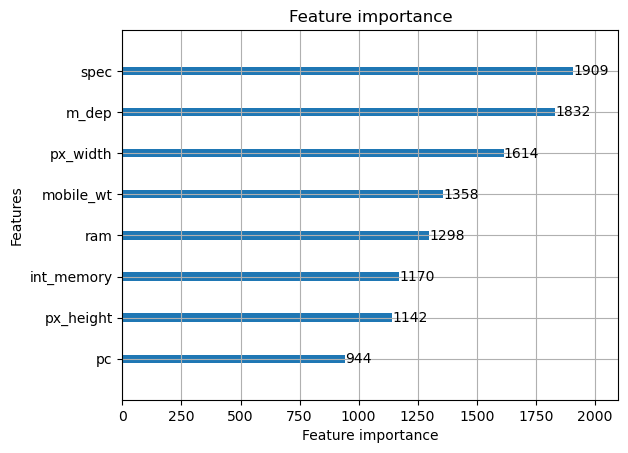

In [9]:
plt.figure(figsize=(10, 6))
lgb.plot_importance(lgb_model)
plt.show()

In [11]:
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softprob', # 多クラス分類
    'num_class': 4, # クラスの数
    'booster': 'gbtree',
    'learning_rate':0.01,
    'max_depth': 5,
}
history = {}
verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
xgb_model = xgb.train(params,
                  train_data,
                  num_boost_round=10000,
                  # feval=f1,
                  early_stopping_rounds=50,
                  evals=[(train_data, "train"), (test_data, "test")],
                  evals_result=history,
                 )

y_pred = xgb_model.predict(test_data)
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class

[13:04:18] WARNING: ../src/learner.cc:767: 
Parameters: { "metric", "n_estimators" } are not used.

[0]	train-mlogloss:1.38057	test-mlogloss:1.38204
[1]	train-mlogloss:1.37495	test-mlogloss:1.37788
[2]	train-mlogloss:1.36943	test-mlogloss:1.37381
[3]	train-mlogloss:1.36397	test-mlogloss:1.36987
[4]	train-mlogloss:1.35862	test-mlogloss:1.36597
[5]	train-mlogloss:1.35332	test-mlogloss:1.36217
[6]	train-mlogloss:1.34814	test-mlogloss:1.35843
[7]	train-mlogloss:1.34301	test-mlogloss:1.35474
[8]	train-mlogloss:1.33793	test-mlogloss:1.35101
[9]	train-mlogloss:1.33296	test-mlogloss:1.34741
[10]	train-mlogloss:1.32808	test-mlogloss:1.34387
[11]	train-mlogloss:1.32322	test-mlogloss:1.34042
[12]	train-mlogloss:1.31846	test-mlogloss:1.33692
[13]	train-mlogloss:1.31381	test-mlogloss:1.33372
[14]	train-mlogloss:1.30919	test-mlogloss:1.33033
[15]	train-mlogloss:1.30461	test-mlogloss:1.32714
[16]	train-mlogloss:1.30012	test-mlogloss:1.32397
[17]	train-mlogloss:1.29575	test-mlogloss:1.32077
[18]	train

array([2, 2, 1, 2, 1, 1, 3, 2, 0, 1, 2, 1, 1, 0, 2, 3, 2, 1, 0, 3, 1, 2,
       2, 2, 0, 2, 2, 2, 2, 3, 1, 2, 3, 3, 3, 1, 1, 0, 2, 2, 1, 2, 2, 2,
       1, 3, 3, 3, 3, 3, 2, 0, 1, 2, 3, 2, 2, 1, 3, 2, 1, 2, 1, 2, 2, 1,
       3, 2, 2, 0, 2, 3, 2, 2, 3, 3, 3, 0, 0, 1, 1, 3, 3, 1, 0, 0, 2, 3,
       1, 2, 2, 2, 0, 2, 1, 2, 1, 0, 1, 2, 3, 1, 1, 1, 1, 3, 1, 3, 2, 3,
       1, 1, 2, 3, 2, 3, 3, 3, 1, 2, 1, 3, 3, 1, 0, 0, 1, 1, 1, 3, 1, 0,
       3, 0, 3, 1, 1, 1, 2, 3, 3, 0, 3, 1, 1, 3, 3, 1, 3, 2, 2, 0, 1, 2,
       3, 2, 1, 1, 0, 1, 2, 3, 1, 2, 1, 2, 1, 1, 3, 0, 3, 1, 2, 1, 2, 0,
       3, 2, 1, 1, 0, 3, 0, 3, 2, 1, 0, 1, 1, 0, 1, 0, 2, 1, 1, 2, 0, 2,
       2, 2, 0, 1, 0, 0, 3, 3, 2, 0, 3, 1, 1, 1, 1, 3, 1, 1, 3, 2, 3, 1,
       1, 2, 2, 0, 1, 1, 2, 3, 1, 0, 1, 2, 2, 1, 1, 1, 3, 3, 1, 0])

In [12]:
print(accuracy_score(y_test, y_pred_class))

score = f1_score(y_test, y_pred_class, average='macro')
score

0.475


0.45168003018266334

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

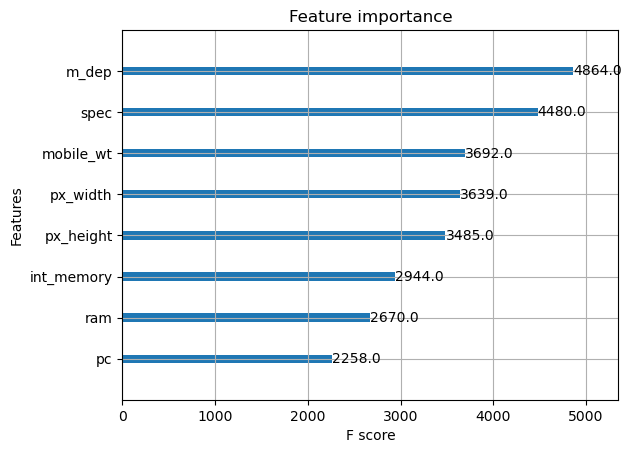

In [13]:
xgb.plot_importance(xgb_model)

In [50]:
# from sklearn.model_selection import KFold
# # クロスバリデーション用のScikit-Learnクラス（5分割KFold）
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ###### ここからがLightGBMの実装 ######
# # データをDatasetクラスに格納
# dcv = lgb.Dataset(X, label=y)  # クロスバリデーション用
# # 使用するパラメータ
# params = {
#     'objective': 'multiclass', # 多クラス分類
#     'num_class': 4, # クラスの数
#     'metric': 'multi_logloss', # 損失関数にmulti_loglossを使用
#     'random_state': 42,  # 乱数シード
#     'boosting_type': 'gbdt',
#     'reg_alpha': 0.0,
#     'reg_lambda': 0.0,
#     'learning_rate':0.01, 
#     'drop_rate':0.5,
#     'verbose': -1
# }
# verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
# # early_stoppingを指定してLightGBMをクロスバリデーション
# cv_result = lgb.cv(params, dcv,
#                 num_boost_round=10000,  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
#                 folds=cv,
#                 feval=f1,
#                 callbacks=[lgb.early_stopping(stopping_rounds=100, 
#                                 verbose=True), # early_stopping用コールバック関数
#                            lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
#                 )
# # print(cv_result)
# print(f'multi logloss mean={cv_result["multi_logloss-mean"][-1]}')

# test_data = preprocessing(df_test)
# pred = ddmodel.predict(test_data)
# pred_class = np.argmax(pred, axis=1)
# pred_class

In [14]:
test_data = preprocessing(df_test)
# pred = model.predict(test_data)
# pred_class = np.argmax(pred, axis=1)

emsemble_test = pd.DataFrame({
    'XGB': np.argmax(xgb_model.predict(xgb.DMatrix(test_data)), axis=1),
    'LGB': np.argmax(lgb_model.predict(test_data), axis=1)
    })
emsemble_test

,XGB,LGB
0,3,1
1,2,2
2,3,0
3,3,1
4,3,2
...,...,...
795,0,0
796,1,1
797,3,2
798,2,2


In [15]:
mean = emsemble_test['LGB'] * 0.8 + emsemble_test['XGB'] * 0.2
pred_class = mean.round().astype(int)
pred_class

0      1
1      2
2      1
3      1
4      2
      ..
795    0
796    1
797    2
798    2
799    2
Length: 800, dtype: int64

In [53]:
# sample_submission['2'] = proba
submission = pd.concat([df_test['id'], pd.DataFrame(pred_class)], axis=1)
submission = submission.rename(columns={'id': 1})
submission

,1,0
0,1,1
1,2,2
2,6,1
3,10,1
4,12,2
...,...,...
795,1978,2
796,1980,1
797,1982,2
798,1988,2


In [54]:
# 保存
save_folder = "results"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

submission.to_csv("{}/submit_{}.csv".format(save_folder, datetime.now().strftime("%Y-%m-%d-%H%M%S")),index=False, header=None)